In [166]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
 


In [207]:

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [208]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez



Note that the test and train data have the same format except the test data doesn't have a transported column.   I am going to add a 'Train' column to make seperating these easier and then later join them up.

In [209]:
train_data['Train']= True
test_data['Train'] = False

all_data = pd.concat([train_data,test_data]).reset_index(drop=True)

## Examine and PreProcess data

Missing data?

In [210]:
all_data.apply(lambda x:np.sum(x.isna()))/all_data.count()

PassengerId     0.000000
HomePlanet      0.022709
CryoSleep       0.024487
Cabin           0.023597
Destination     0.021582
Age             0.021260
VIP             0.023355
RoomService     0.020697
FoodCourt       0.022790
ShoppingMall    0.024163
Spa             0.022387
VRDeck          0.021099
Name            0.023193
Transported     0.492005
Train           0.000000
dtype: float64

Each column has about 2% missing data.

In [211]:
def plot_transported_rate(data, col):
    survival  = data[["Transported",col]].groupby(col).mean().reset_index()
    sns.barplot(data=survival,x=col, y='Transported')

### Home Planet

<AxesSubplot:xlabel='HomePlanet', ylabel='Count'>

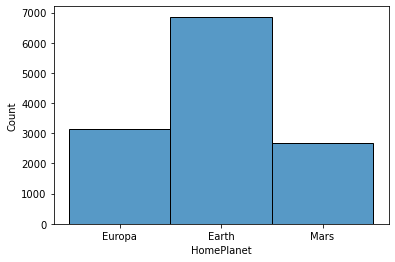

In [212]:
sns.histplot(all_data['HomePlanet'])

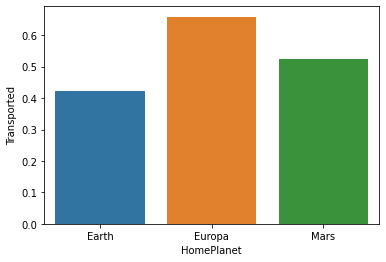

In [213]:
plot_transported_rate(all_data[all_data["Train"]], "HomePlanet")

Ok home planet is most commonly earth, so we will fill in Earth for missing ones. We also want to make this Categorical. 

In [214]:
all_data.loc[all_data.HomePlanet.isna(),"HomePlanet"] = "Earth"

In [215]:
all_data = all_data.join(pd.get_dummies(all_data["HomePlanet"], prefix="HP", drop_first=True)) # Earth is baseline

### Cryosleep

In [216]:
all_data['CryoSleep'] = all_data['CryoSleep'].astype('category') 

In [217]:
all_data['CryoSleep'].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [218]:
all_data.loc[all_data["CryoSleep"].isna(),"CryoSleep"] = False 

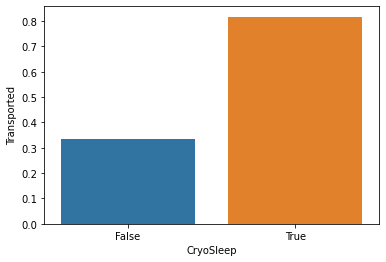

In [219]:
plot_transported_rate(all_data[all_data["Train"]], "CryoSleep")

Cryosleep is a STRONG predictor of being transported

### Cabin 

This one is a bit tricky as there is clearly useful information from this but we are going to have to parse it out abit. First look at all the non-na.  REMEMBER DO NOT combine these with the original data yet.

In [180]:
cabin_temp = all_data.loc[all_data.Cabin.notna(),["Cabin","Transported", "Train"]].reset_index(drop=True)

cabin_dat =pd.DataFrame(cabin_temp["Cabin"].map(lambda x: x.split('/')).to_list(), columns= ["Class","Number","PS"])

cabin_comb = cabin_temp.join(cabin_dat)
cabin_comb.head()

,Cabin,Transported,Train,Class,Number,PS
0,B/0/P,False,True,B,0,P
1,F/0/S,True,True,F,0,S
2,A/0/S,False,True,A,0,S
3,A/0/S,False,True,A,0,S
4,F/1/S,True,True,F,1,S


In [181]:
cabin_comb.apply(lambda x:np.sum(x.isna()))

Cabin             0
Transported    4177
Train             0
Class             0
Number            0
PS                0
dtype: int64

<AxesSubplot:xlabel='Class', ylabel='Count'>

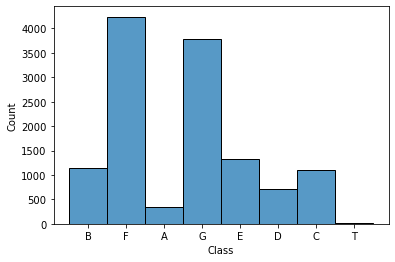

In [182]:
sns.histplot(cabin_comb["Class"])

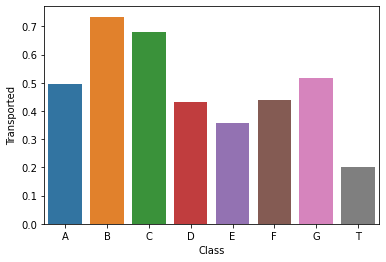

In [183]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]], "Class")

Class seems to effect transport rate

In [184]:
cabin_comb["PS"].describe()   #Port Starboard?

count     12671
unique        2
top           S
freq       6381
Name: PS, dtype: object

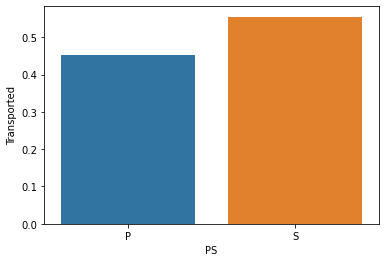

In [185]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]] , "PS")

Hmm.. port starboard might matter too!  Not sure how do deal with the missing values in this event.  Possibly add a third category = missing

In [186]:
cabin_comb["Number"].astype("int").describe()

count    12671.000000
mean       603.601926
std        512.891926
min          0.000000
25%        170.000000
50%        431.000000
75%       1008.000000
max       1894.000000
Name: Number, dtype: float64

In [187]:
cabin_comb["Number"] = cabin_comb["Number"].astype("int")

In [188]:
cabin_comb["Num_Cat"] = pd.qcut(cabin_comb["Number"],8)

In [189]:
cabin_comb.head()

,Cabin,Transported,Train,Class,Number,PS,Num_Cat
0,B/0/P,False,True,B,0,P,"(-0.001, 79.0]"
1,F/0/S,True,True,F,0,S,"(-0.001, 79.0]"
2,A/0/S,False,True,A,0,S,"(-0.001, 79.0]"
3,A/0/S,False,True,A,0,S,"(-0.001, 79.0]"
4,F/1/S,True,True,F,1,S,"(-0.001, 79.0]"


In [190]:
cabin_comb["Num_Cat"].value_counts()

(-0.001, 79.0]      1599
(170.0, 267.0]      1591
(682.75, 1008.0]    1588
(1338.0, 1894.0]    1583
(431.0, 682.75]     1582
(1008.0, 1338.0]    1581
(267.0, 431.0]      1574
(79.0, 170.0]       1573
Name: Num_Cat, dtype: int64

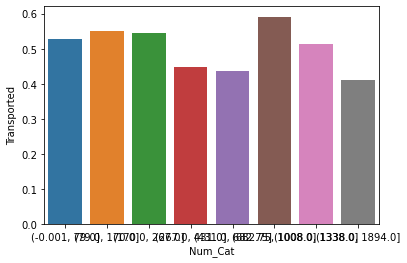

In [191]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]], "Num_Cat")

Seems like the number matters... but for a first pass I will skip on it.  Ok so here is what we will do for this case: 

* Split out all the no-na values .  drop cabin number. 

* Set class = 'F" and PS = 'Uknown"  for na's

In [220]:
def get_class_ps(x):
    if pd.isna(x):
        return ['F','Unknown']
    else:
        (c,num,ps) = x.split('/')
        return [c,ps]

cabin_dat = pd.DataFrame(all_data["Cabin"].map(get_class_ps).to_list(), columns= ["Class","PS"])

 

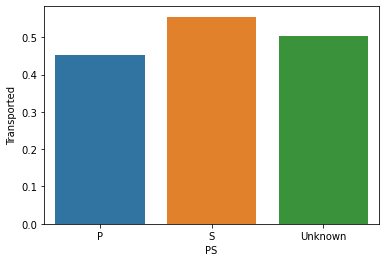

In [221]:
all_data = all_data.join(cabin_dat)
plot_transported_rate(all_data[all_data["Train"]] , "PS")

In [222]:
all_data["PS"].value_counts()

S          6381
P          6290
Unknown     299
Name: PS, dtype: int64

The 300 'Uknown" are probably not going to be worth much in training, but i will leave it this way. For the rest I will replace with mode or mean 

In [223]:
all_data = all_data.join(pd.get_dummies(all_data["PS"],prefix="SIDE", drop_first=True) )
all_data = all_data.join(pd.get_dummies(all_data["Class"], prefix="Class", drop_first=True))
all_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,PS,SIDE_S,SIDE_Unknown,Class_B,Class_C,Class_D,Class_E,Class_F,Class_G,Class_T
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,P,0,0,1,0,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,S,1,0,0,0,0,0,1,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,S,1,0,0,0,0,0,0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,S,1,0,0,0,0,0,0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,S,1,0,0,0,0,0,1,0,0


In [224]:
all_data = all_data.drop(columns = ["HomePlanet","Cabin","Class","PS"])
all_data.head()

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,HP_Mars,SIDE_S,SIDE_Unknown,Class_B,Class_C,Class_D,Class_E,Class_F,Class_G,Class_T
0,0001_01,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0002_01,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,0,1,0,0,0,0,0,1,0,0
2,0003_01,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,0,1,0,0,0,0,0,0,0,0
3,0003_02,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,0,1,0,0,0,0,0,0,0,0
4,0004_01,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,0,1,0,0,0,0,0,1,0,0


Note that Class A is baseline, as is Port

### Destination

<AxesSubplot:xlabel='Destination', ylabel='Count'>

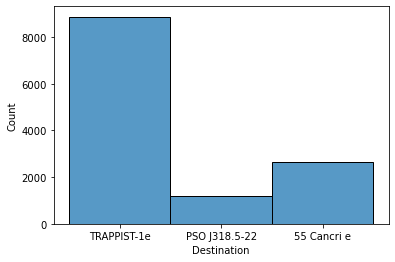

In [225]:
sns.histplot(all_data["Destination"])

In [226]:
all_data.loc[all_data["Destination"].isna(), "Destination"] = all_data["Destination"].mode()
all_data["Destination"] = all_data["Destination"].astype("category")

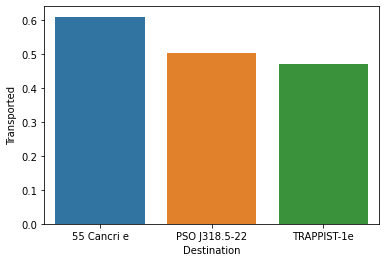

In [227]:
plot_transported_rate(all_data[all_data["Train"]] , "Destination")

In [231]:
all_data = all_data.join(pd.get_dummies(all_data["Destination"], prefix="Dest")).drop(columns = ["Destination",'Dest_TRAPPIST-1e'])
all_data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,SIDE_Unknown,Class_B,Class_C,Class_D,Class_E,Class_F,Class_G,Class_T,Dest_55 Cancri e,Dest_PSO J318.5-22
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,1,0,0,0,0,0,0,0,0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0,0,0,0,0,1,0,0,0,0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,0,0,0,0,0,0,0,0,0,0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,0,0,0,0,0,0,0,0,0,0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,0,0,0,0,0,1,0,0,0,0


TRAPPIST-1e is baseline here.

### Age

In [200]:
all_data.Age.describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [232]:
all_data.loc[all_data["Age"].isna(),"Age"] = np.mean(all_data.Age)

In [202]:
all_data["Age_Cat"]  = pd.cut(all_data["Age"],[0,12,21,30,60,100])

In [203]:
all_data["Age_Cat"].value_counts()

(30, 60]     4715
(21, 30]     3808
(12, 21]     2963
(0, 12]       897
(60, 100]     327
Name: Age_Cat, dtype: int64

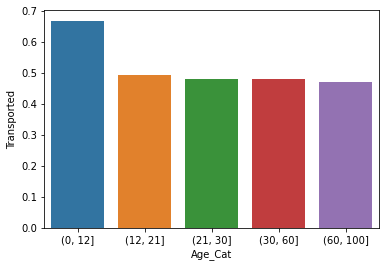

In [204]:
plot_transported_rate(all_data[all_data["Train"]] , "Age_Cat")

In [233]:
all_data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,SIDE_Unknown,Class_B,Class_C,Class_D,Class_E,Class_F,Class_G,Class_T,Dest_55 Cancri e,Dest_PSO J318.5-22
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,1,0,0,0,0,0,0,0,0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0,0,0,0,0,1,0,0,0,0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,0,0,0,0,0,0,0,0,0,0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,0,0,0,0,0,0,0,0,0,0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,0,0,0,0,0,1,0,0,0,0


### VIP

In [235]:
all_data.VIP.value_counts()

False    12401
True       273
Name: VIP, dtype: int64

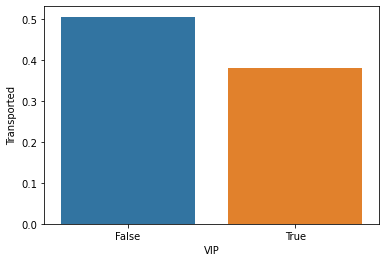

In [236]:
all_data.loc[all_data["VIP"].isna(),"VIP"] = False
plot_transported_rate(all_data[all_data["Train"]] , "VIP")

### Spending

### Re-devide data

In [205]:
# Now split it back out

test_data = all_data[~all_data["Train"]].drop(columns="Train").reset_index(drop=True)

train_data = all_data[all_data["Train"]].drop(columns="Train").reset_index(drop=True)


## Try to fit a logistic regression

# Apply best model to test data.